# Using visual analytics to support data analysis

This was part of my final submission for a visual analytics module where we were encouraged to think of visualisations as crucial to our work flow. 

In this notebook I'm seeking to answer the question: **To what entent do UNICEF's African regions marry with HIV/AIDS health data in the region?**

Work flow:
1. Clean and process the data
2. Use k-means to cluster country specific data into three groups
3. Use confusion matrices to investigate model outputs, comparing our k-means output to the three "true" Unicef regions
4. Use PCA to reduce dimensions into a meaningul 2D representation, to appreciate how well our three clusters marry with the three Unicef regions
5. Use the folium and geopandas libraries to produce a geoplot to clearly see the agreement

Findings
* There is broad agreement between the predicted and true regions, showing that the HIV/AIDS indicators in the data are common to a geographical region which match closely to Unicef's designated regions.
* This analysis can support the work of NGOs by appreciating which countries within a designated region have characteristics more closely related to another and should therefore get different support. For example, the island nation of Madagascar is more closely aligned to Unicef’s MENA region and health campaigns can be applied accordingly.

Notes:
This project was completed three months into my Masters, with no significant prior coding experience. Some of my approaches with pandas might be a bit naive but I'm really happy with the overall project which also included work on the mpox outbreak of 2022.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import geopandas as gpd
import folium as fm
import requests
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Load and tidy up data (1)

The data in this project is sourced from NGOs in a variety of formats. We use pandas to work with the dataframes. Our aim here is to distill the data to just Africa with a good set of potential indicators, such as "Estimated incidence rate", with comparible attributes (eg the year).

In [2]:
# import data
# we use low_memory=False to avoid a warning on setting dtypes in the import
# we are only working with a small dataset so this is acceptable

# UNICEF dataset - HIV/AIDS in children
df_ha=pd.read_csv("data/HIV_Epidemiology_Children_Adolescents_2023.csv",low_memory=False)
# Homemade dataset via Unicef data warehouse with extra variables - will have missing values
df_hm=pd.read_csv("data/HIV_all_pop.csv",low_memory=False)

# print shapes
print(df_ha.shape)
print(df_hm.shape)

(205238, 12)
(6456, 22)


In [3]:
# quick overview of df1
# print columns and first 3 rows
print(f"df_ha columns: {df_ha.columns}")
df_ha.head(3)

df_ha columns: Index(['ISO3', 'Type', 'Country/Region', 'UNICEF Region', 'Indicator',
       'Data source', 'Year', 'Sex', 'Age', 'Value', 'Lower', 'Upper'],
      dtype='object')


,ISO3,Type,Country/Region,UNICEF Region,Indicator,Data source,Year,Sex,Age,Value,Lower,Upper
0,03M49WLD,Region,Global,NaN,Estimated incidence rate (new HIV infection pe...,UNAIDS 2023 estimates,2000,Both,Age 0-14,0.89,0.60,1.38
1,03M49WLD,Region,Global,NaN,Estimated incidence rate (new HIV infection pe...,UNAIDS 2023 estimates,2000,Both,Age 15-19,0.70,0.18,1.26
2,03M49WLD,Region,Global,NaN,Estimated incidence rate (new HIV infection pe...,UNAIDS 2023 estimates,2000,Female,Age 0-14,0.90,0.61,1.40


In [4]:
# and again of df2
print(f"df_hm columns: {df_hm.columns}")
df_hm.head(3)

df_hm columns: Index(['DATAFLOW', 'REF_AREA:Geographic area', 'INDICATOR:Indicator',
       'SEX:Sex', 'TIME_PERIOD:Time period', 'OBS_VALUE:Observation Value',
       'UNIT_MULTIPLIER:Unit multiplier', 'UNIT_MEASURE:Unit of measure',
       'OBS_STATUS:Observation Status', 'OBS_CONF:Observation confidentaility',
       'LOWER_BOUND:Lower Bound', 'UPPER_BOUND:Upper Bound',
       'WGTD_SAMPL_SIZE:Weighted Sample Size',
       'OBS_FOOTNOTE:Observation footnote', 'SERIES_FOOTNOTE:Series footnote',
       'DATA_SOURCE:Data Source',
       'SOURCE_LINK:Citation of or link to the data source',
       'CUSTODIAN:Custodian',
       'TIME_PERIOD_METHOD:Time period activity related to when the data are collected',
       'REF_PERIOD:Reference Period',
       'COVERAGE_TIME:The period of time for which data are provided',
       'AGE:Current age'],
      dtype='object')


,DATAFLOW,REF_AREA:Geographic area,INDICATOR:Indicator,SEX:Sex,TIME_PERIOD:Time period,OBS_VALUE:Observation Value,UNIT_MULTIPLIER:Unit multiplier,UNIT_MEASURE:Unit of measure,OBS_STATUS:Observation Status,OBS_CONF:Observation confidentaility,...,WGTD_SAMPL_SIZE:Weighted Sample Size,OBS_FOOTNOTE:Observation footnote,SERIES_FOOTNOTE:Series footnote,DATA_SOURCE:Data Source,SOURCE_LINK:Citation of or link to the data source,CUSTODIAN:Custodian,TIME_PERIOD_METHOD:Time period activity related to when the data are collected,REF_PERIOD:Reference Period,COVERAGE_TIME:The period of time for which data are provided,AGE:Current age
0,UNICEF:GLOBAL_DATAFLOW(1.0): Cross-sector indi...,AFG: Afghanistan,CME_MRY0: Infant mortality rate,_T: Total,2019,46.2756344504337,NaN,"D_PER_1000_B: Deaths per 1,000 live births",A: Normal value,NaN,...,NaN,NaN,NaN,UN_IGME,NaN,NaN,NaN,NaN,NaN,_T: Total
1,UNICEF:GLOBAL_DATAFLOW(1.0): Cross-sector indi...,AFG: Afghanistan,CME_MRY0: Infant mortality rate,_T: Total,2020,44.8477159441231,NaN,"D_PER_1000_B: Deaths per 1,000 live births",A: Normal value,NaN,...,NaN,NaN,NaN,UN_IGME,NaN,NaN,NaN,NaN,NaN,_T: Total
2,UNICEF:GLOBAL_DATAFLOW(1.0): Cross-sector indi...,AFG: Afghanistan,CME_MRY0: Infant mortality rate,_T: Total,2021,43.3916302547615,NaN,"D_PER_1000_B: Deaths per 1,000 live births",A: Normal value,NaN,...,NaN,NaN,NaN,UN_IGME,NaN,NaN,NaN,NaN,NaN,_T: Total


### Start tidying up

In [5]:
# focus on 2022
df_ha=df_ha[df_ha.Year==2022]
df_hm=df_hm[df_hm['TIME_PERIOD:Time period']==2022]

# we don't wish to analyse genders seperately, so only use 'both'
df_ha=df_ha[df_ha.Sex=="Both"]

In [6]:
# remove additional columns of df_hm we will not use
df_hm=df_hm[['REF_AREA:Geographic area', 'INDICATOR:Indicator','OBS_VALUE:Observation Value']]
# pivot
df_hm=df_hm.pivot(values = 'OBS_VALUE:Observation Value', index='REF_AREA:Geographic area', columns = 'INDICATOR:Indicator').reset_index()

In [7]:
# tidy up country/region info
df_hm["Country"]=df_hm["REF_AREA:Geographic area"].apply(lambda x: str(x).split(":")[1].strip())
df_hm["Country code"]=df_hm["REF_AREA:Geographic area"].apply(lambda x: str(x).split(":")[0].strip())

# the data includes rows relating to an entire region as well as countries
# seperate regional and country into two dfs
df_hm_region=df_hm[df_hm["Country code"].str.startswith('UNI')]
df_hm=df_hm[~df_hm["Country code"].str.startswith('UNI')]

In [8]:
# other df
# only take the 0-14 age group and seperate regional and country into two dfs
df_ha=df_ha[df_ha.Age=='Age 0-14']
df_ha_region=df_ha[df_ha.Type=='Region']
df_ha=df_ha[df_ha.Type=='Country']
# pivot
df_ha=df_ha.pivot(values = 'Value', index='Country/Region', columns = 'Indicator').reset_index()
df_ha_region=df_ha_region.pivot(values = 'Value', index='Country/Region', columns = 'Indicator').reset_index()

In [9]:
# pick out African regions
# note Sub_saharan=WCA+ESA
afr_region=['UNICEF_ESA: Eastern and Southern Africa',
            'UNICEF_MENA: Middle East and North Africa',
            #'UNICEF_SSA: Sub-Saharan Africa',
            'UNICEF_WCA: West and Central Africa']
afr_region2=['Eastern and Southern Africa',
             'Middle East and North Africa',
             #'Sub-Saharan Africa',
             'West and Central Africa']
df_hm_afr_region=df_hm_region[df_hm_region['REF_AREA:Geographic area'].isin(afr_region)]
df_ha_afr_region=df_ha_region[df_ha_region['Country/Region'].isin(afr_region2)]
df_hm_afr_region.loc[:,'REF_AREA:Geographic area']=df_hm_region['REF_AREA:Geographic area'].replace(
    {'UNICEF_ESA: Eastern and Southern Africa':"Eastern and Southern Africa",
     'UNICEF_MENA: Middle East and North Africa':"Middle East and North Africa",
     'UNICEF_SSA: Sub-Saharan Africa':'Sub-Saharan Africa',
     'UNICEF_WCA: West and Central Africa': 'West and Central Africa'
     })

# merge the regional dfs
df_afr_region=df_ha_afr_region.merge(df_hm_afr_region, left_on="Country/Region", right_on='REF_AREA:Geographic area')
df_afr_region=df_afr_region.drop(columns=['REF_AREA:Geographic area'])

In [10]:
# start work on merging countries
# there are many more items in df_hm so use df_ha as "left" in our merge
df_country=df_ha.merge(df_hm, left_on="Country/Region", right_on='Country')
df_country=df_country.drop(columns=['REF_AREA:Geographic area',"Country/Region"])

In [11]:
# add Africa region info to countries
esa_list=["Angola","Botswana","Burundi","Comoros","Eritrea","Eswatini","Ethiopia","Kenya","Lesotho","Madagascar","Malawi","Mozambique","Namibia","Rwanda","Somalia","South Africa","South Sudan","United Republic of Tanzania","Uganda","Zambia","Zimbabwe"]
mena_list=["Sudan", "Syria", "Yemen","Algeria", "Egypt", "Iran", "Iraq", "Jordan", "Lebanon", "Libya", "Morocco", "State of Palestine", "Syria", "Tunisia", "Bahrain", "Kuwait", "Oman", "Qatar", "Saudi Arabia", "United Arab Emirates"]
wca_list=["Benin","Burkina Faso", "Cabo Verde", "Cameroon", "Central African Republic", "Chad", "Congo", "Côte d'Ivoire", "Democratic Republic of the Congo", "Equatorial Guinea", "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Liberia", "Mali", "Mauritania", "Niger", "Nigeria", "Sao Tome and Principe", "Senegal", "Sierra Leone", "Togo"]
ssa_list=esa_list+wca_list

def add_region(country):
    if country in esa_list:
        return "esa"
    elif country in mena_list:
        return "mena"
    elif country in wca_list:
        return "wca"
    else:
        return "not"

df_country['afr'] = df_country['Country'].apply(add_region)

In [12]:
# count region membership
print(f"esa: {len(df_country[df_country.afr=="esa"])}")
print(f"mena: {len(df_country[df_country.afr=="mena"])}")
print(f"wca: {len(df_country[df_country.afr=="wca"])}")

esa: 19
mena: 8
wca: 23


In [13]:
# filter to african countries only
df_afr=df_country[df_country.afr!="not"]

In [14]:
# fix floats in the df, we need to strip unwanted characters
float_cols=['Estimated incidence rate (new HIV infection per 1,000 uninfected population)',
       'Estimated number of annual AIDS-related deaths',
       'Estimated number of annual new HIV infections',
       'Estimated number of people living with HIV',
       'Estimated rate of annual AIDS-related deaths (per 100,000 population)',
       'DM_FRATE_TOT: Total fertility rate', 'DM_LIFE_EXP: Life expectancy',
       'DM_POP_TOT: Total population',
       'HVA_EPI_DTH_RT: Estimated rate of annual AIDS-related deaths (per 100,000 population)',
       'HVA_EPI_INF_RT: Estimated incidence rate (new HIV infection per 1,000 uninfected population)',
       'HVA_PMTCT_MTCT: Mother-to-child HIV transmission rate']

for i in float_cols:
     df_afr.loc[:,i]=df_afr.loc[:,i].astype(str)
     df_afr.loc[:,i]=df_afr.loc[:,i].str.strip("<")
     df_afr.loc[:,i]=df_afr.loc[:,i].str.replace(",","")
     df_afr.loc[:,i]=df_afr.loc[:,i].astype(float)

## k means, confusion matrices and PCA (2-4)

The idea here is to find a way to measure how well the countries align with their region. So, if we use k-means with three clusters (using the indicators from part), does this "look" like the true three UNICEF regions? How can we tell? The latter comes from a confusion matrix and a PCA plot

In [15]:
# preprocessing for k means
# rescaling is necessary for inputting into most ML methods
for i in float_cols:
    df_afr.loc[:,i]=(df_afr[i]-df_afr[i].min())/(df_afr[i].max()-df_afr[i].min())

# no nan or non-numeric info for the the k means input
# this has an impact, a few countries are no longer included, but this is minimal
df_afr_k=df_afr.copy()
df_afr_k=df_afr_k.dropna()
df_afr_kc=df_afr_k[float_cols]


In [16]:
# Set up our k means
kmeans_afr = KMeans(n_clusters=3, random_state=123,n_init="auto")
# fitting the algorithm to the data
kmeans_afr = kmeans_afr.fit(df_afr_kc)
# getting the Cluster labels for the dataframe
labels = kmeans_afr.predict(df_afr_kc)+1
df_afr_k.loc[:,'Cluster id']=labels

# getting cluster sizes
cluster_sizes = df_afr_k['Cluster id'].value_counts().rename_axis('Cluster id').to_frame('counts')
print("Cluster sizes:")
print(cluster_sizes)

max_cluster_size=cluster_sizes['counts'].max()
print("max = ",max_cluster_size)

# getting the centroid values
centroids = kmeans_afr.cluster_centers_

print("\nCluster centroids:")
print(centroids)

Cluster sizes:
            counts
Cluster id        
1               27
3               11
2               10
max =  27

Cluster centroids:
[[0.10590463 0.04660494 0.04229113 0.02020846 0.11531866 0.45211879
  0.46977673 0.16369595 0.06034381 0.03436551 0.52262166]
 [0.6399361  0.23571429 0.27449612 0.2477599  0.58385423 0.38989322
  0.23487287 0.11873632 0.51615886 0.56901639 0.28715964]
 [0.18123729 0.27597403 0.27131783 0.19648859 0.18829064 0.48477319
  0.39948589 0.39480919 0.17397209 0.10581222 0.26484007]]


Next, we will use PCA to see if our three clusters marry with the three true regions (recall, we have the regional summary stats in the data). 

In [17]:
# regional df - same float tidy up
for i in float_cols:
     df_afr_region.loc[:,i]=df_afr_region.loc[:,i].astype(str)
     df_afr_region.loc[:,i] = df_afr_region.loc[:,i].str.strip("<")
     df_afr_region.loc[:,i]=df_afr_region.loc[:,i].str.replace(",","")
     df_afr_region.loc[:,i]=df_afr_region[i].astype(float)

# rescale
for i in float_cols:
    df_afr_region[i]=(df_afr_region[i]-df_afr_region[i].min())/(df_afr_region[i].max()-df_afr_region[i].min())

In [18]:
# prepare for PCA
df_afr_region_c=df_afr_region.iloc[:,1:12]
df_afr_region_c["Region"]=["ESA","MENA","WCA"]
df_afr_kmeans_c=pd.DataFrame(kmeans_afr.cluster_centers_,columns=df_afr_region_c.columns[0:11])
df_afr_kmeans_c["cluster"]=[3,2,1]

# rescale
for i in float_cols:
    df_afr_kmeans_c[i]=(df_afr_kmeans_c[i]-df_afr_kmeans_c[i].min())/(df_afr_kmeans_c[i].max()-df_afr_kmeans_c[i].min())
    
# append dfs - this will be the PCA representation of the three clusters and three regions
df_afr_c=pd.concat([df_afr_kmeans_c,df_afr_region_c])

pca1 = PCA(n_components=2)
df_pca_c=pd.DataFrame(pca1.fit_transform(df_afr_c.iloc[0:3,0:11]))
df_pca_r=pd.DataFrame(pca1.fit_transform(df_afr_c.iloc[3:6,0:11]))
df_pca=pd.concat([df_pca_c,df_pca_r])
df_pca=df_pca.rename(columns={0: "PCA1", 1: "PCA2"})
df_pca["original"]=["Cluster 1","Cluster 2","Cluster 3","ESA","MENA","WCA"]
df_pca['colour']=["tab:green","tab:green","tab:green","tab:pink","tab:pink","tab:pink"]
df_pca=df_pca.reset_index()

df_pca

,index,PCA1,PCA2,original,colour
0,0,-1.426924,-0.622114,Cluster 1,tab:green
1,1,1.564398,-0.471355,Cluster 2,tab:green
2,2,-0.137474,1.093469,Cluster 3,tab:green
3,0,-1.342555,-0.518644,ESA,tab:pink
4,1,1.765558,-0.217915,MENA,tab:pink
5,2,-0.423003,0.736559,WCA,tab:pink


In [107]:
# investiagte the output of the PCA - which variables contributed most?
print(pca1.explained_variance_)

df_components1=pd.DataFrame(pca1.components_)
df_components1.columns=float_cols
df_components1=abs(df_components1)
df_components1=df_components1.transpose()
df_components1=df_components1.rename(columns={0: "PCA1", 1: "PCA2"})
df_components1=df_components1.sort_values(by=['PCA1'], ascending=False)

df_components1

[2.5492913  0.42949855]


,PCA1,PCA2
Estimated number of annual AIDS-related deaths,0.341610,0.205377
Estimated number of annual new HIV infections,0.332279,0.108941
"Estimated rate of annual AIDS-related deaths (per 100,000 population)",0.330306,0.088544
DM_POP_TOT: Total population,0.325331,0.037133
"Estimated incidence rate (new HIV infection per 1,000 uninfected population)",0.320280,0.015072
Estimated number of people living with HIV,0.297471,0.250813
"HVA_EPI_DTH_RT: Estimated rate of annual AIDS-related deaths (per 100,000 population)",0.293910,0.287619
HVA_PMTCT_MTCT: Mother-to-child HIV transmission rate,0.289426,0.333956
"HVA_EPI_INF_RT: Estimated incidence rate (new HIV infection per 1,000 uninfected population)",0.278404,0.447876
DM_LIFE_EXP: Life expectancy,0.255654,0.461495


Text(0, 0.5, 'PCA2')

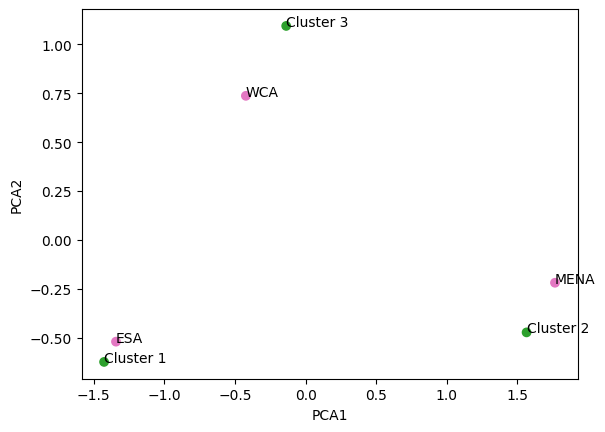

In [19]:
# visualise - are the clusters differentiatable to a region?
fig, ax = plt.subplots()
ax.scatter(df_pca.PCA1, df_pca.PCA2,c=df_pca.colour)

for i, txt in enumerate(df_pca.original):
    ax.annotate(txt, (df_pca.PCA1[i], df_pca.PCA2[i]))

plt.xlabel('PCA1')
plt.ylabel('PCA2')

This plot shows very clear alignment between the k-Means clusters and the true regions. Simply put, if you divide Africa into three regions based on HIV/AIDS data, it will broadly agree with the three geographical regions designated by UNICEF.

We validate this conclusion further with a confusion matrix but shgould note that this was an analytical project and it wasn't our intention to actually predict a countries region based on the data.

In [22]:
# Back to clustering of countries
df_afr_k.loc[:,"AFR"]=df_afr_k["afr"].str.upper()

In [25]:
df_afr_k.loc[:,"AFR_P"]=None
df_afr_k.loc[df_afr_k["Cluster id"]==1, 'AFR_P'] = "MENA"
df_afr_k.loc[df_afr_k["Cluster id"]==2, 'AFR_P'] = "ESA"
df_afr_k.loc[df_afr_k["Cluster id"]==3, 'AFR_P'] = "WCA"

<Axes: >

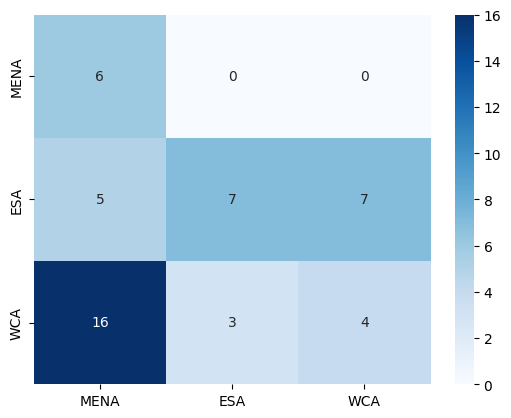

In [26]:
# confusion matrix - do the clusters marry with the true regions?
y_true = df_afr_k["AFR"]
y_pred = df_afr_k["AFR_P"]
cm=confusion_matrix(y_true, y_pred,labels=["MENA","ESA","WCA"])

sns.heatmap(cm, annot=True, cmap='Blues',xticklabels=["MENA","ESA","WCA"],yticklabels=["MENA","ESA","WCA"])

The confusion matrix helps us appreciate accuracy, recall and precision. For instance, all MENA were predicted correctly, but many WCA counties were "wrongly" identified as MENA. The subsequent geoplot shows helps us understand this better.

## Geoplot (5)

The clearest way to summarise the findings and communicate them to a wider audience is with a map. Here we use geopandas and folium.

In [112]:
# Prepare geodata
# we need the polygon data to 'draw' the map
geo_url="https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json"
response=requests.get(geo_url)
geojson=response.json()

In [113]:
M=fm.Map(tiles='Stamen Toner', attr="<a href=https://maps.stamen.com/>Stamen Toner</a>")

fm.Choropleth(
    geo_data=geojson,
    data=df_afr_k,
    columns=["Country code","Cluster id"],
    key_on='feature.id',
    fill_color="Set2"
    ).add_to(M)

M

In [117]:
# Compare to "true" regional
df_afr_k2=df_afr_k
df_afr_k2.loc[:,'afr2']=df_afr_k2['afr']
# need to change categorical to numeric
# Note - amend numbers to make them match with above.
df_afr_k2.loc[:,'afr2']=df_afr_k2.loc[:,'afr2'].replace({"mena":1,"wca":3,"esa":2}) 

In [118]:
# Visualise "true" regions
M2=fm.Map(tiles='Stamen Toner', attr="<a href=https://maps.stamen.com/>Stamen Toner</a>")

fm.Choropleth(
    geo_data=geojson,
    data=df_afr_k2,
    columns=["Country code","afr2"],
    key_on='feature.id',
    fill_color="Set2"
    ).add_to(M2)

M2

These plots may not be visible, so here are screeenshots

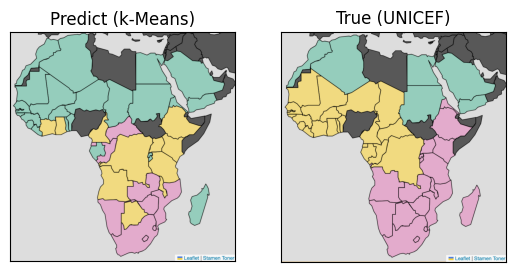

In [13]:
file_names=['images/img_true.png','images/img_predict.png']
plot_titles=["Predict (k-Means)","True (UNICEF)"]
fig, axs=plt.subplots(1,2)
for i,img in enumerate(file_names):
    axs[i].imshow(mpimg.imread(img))
    axs[i].set_title(plot_titles[i])
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)